
### План работ:

1. [Часть первая приритезация гипотез:](#part1)
    - [Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.](#ice)
    - [Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.](#rice)
    - [Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.](#itog)

2. [Часть вторая анализ А/В теста:](#part2)
    - [Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.](#p1)
    - [Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.](#p1)
    - [Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.](#p1)
    - [Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.](#p2)
    - [Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.](#p2)
    - [Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.](#p3)
    - [Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.](#p3)
    - [Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.](#p3)
    - [Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.](#p3)
    - [Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.](#p4)
    - [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.](#p4)
    - [Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.](#p4)
    - [Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.](#p4)
    - [Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.](#total)


## Приоретизация гипотез<a id="part1"></a>

**Описание данных:**
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [1]:
# импортируем библиотеки которые нам понадобяться
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math as mth
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
def check_data(data):
    """Функция просмотра данных info describe и проверка пропусков"""
    duplicate_dict = {}
    isnull_dict = {}
    display(data.info())
    display(data.describe())
    for value in data.columns:
        duplicate_dict[value] = data[value].duplicated().sum()
        isnull_dict[value] = data[value].isnull().sum()
        tmp_df = pd.DataFrame([duplicate_dict, isnull_dict])
    tmp_df.index = ['Дубликатов в колонке', 'Пропусков в колонке']
    tmp_df = tmp_df.style.applymap(lambda x: 'color:darkred' if x > 0 else 'color:white')
    print(f'Количество строк = {data.shape[0]}, количество столбцов = {data.shape[1]}\n')
    print('Всего дубликатов в таблице = ', data.duplicated().sum())
    return display(tmp_df)

In [3]:
# откроем датасет с гипотезами
try:
    hyp_data = pd.read_csv('data/hypothesis.csv') # локальный путь
except:
    hyp_data = pd.read_csv('/datasets/hypothesis.csv') # путь Яндекса

In [4]:
# просмотрим данные
check_data(hyp_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Количество строк = 9, количество столбцов = 5

Всего дубликатов в таблице =  0


,Hypothesis,Reach,Impact,Confidence,Efforts
Дубликатов в колонке,0,3,2,2,3
Пропусков в колонке,0,0,0,0,0


***Данные содержат 5 колонок и 9 строк, пропусков нет, можно работать дальше, дубликаты здесь обоснованые, так как в разных строках значения могу повторяться но тем не менее это разные гипотезы***

In [5]:
# найдем самую длинную строку для отобржения всей длинны строки гипотезы
# зададим параметр options.display.max_colwidth
res = []
for s in hyp_data['Hypothesis']:
    res.append(len(s))
    
print('Самая длинная строка',max(res))
pd.options.display.max_colwidth = max(res) + 10 # прибавим 10 символом, чтобы наверняка

Самая длинная строка 108


In [6]:
# воспользуемся ICE фреймфорком для анализа гипотез
hyp_data['ICE'] = (hyp_data['Impact'] * hyp_data['Confidence']) / hyp_data['Efforts']
display(hyp_data.sort_values(by = 'ICE', ascending = False)[['Hypothesis', 'ICE']])

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


***Согласно ICE лидируют гипотезы:***<a id="ice"></a>
1. Запустить акцию, дающую скидку на товар в день рождения	
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

In [7]:
# воспользуемся RICE фреймворком для определния приоритета гипотез
hyp_data['RICE'] = (hyp_data['Reach'] * hyp_data['Impact'] * hyp_data['Confidence']) / hyp_data['Efforts']
display(hyp_data.sort_values(by = 'RICE', ascending = False)[['Hypothesis', 'RICE']])

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


***Согласно RICE лидируют гипотезы:*** <a id="rice"></a>
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок		
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей		

In [8]:
display(hyp_data)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


## Выводы после приоретизации гипотез <a id="itog"></a>
1. ICE показал приритет гиппотез в таком порядке: Запустить акцию, дающую скидку на товар в день рождения.
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

2. RICE показал другой приоритет: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

3. Приоретизация в случае RICE изменилась и вот почему:
    - ICE не учитывает параметр REACH, поэтому акция в день рождения лидирует в ICE ведь это заденет лишь 1 человека, здесь и ICE и RICE имеют равный показатель, а в случае с RICE она занимает лишь 5 место.
    - 3-е место в ICE занимает добавление формы подписки чтобы собрать базу клиентов, опять же здесь параметр REACH дает 10ти кратное уножение в пользу этой гипотезы в случае с RICE при техже условиях эта гипотеза первая в списке.
    - В случае с добавлением двух новых каналов трафика и привлечь 30% пользователей, в случае с ICE это вторая по значимости гипотеза так как ее показатели влияния на пользователя 10 и уверненность 8 при стоимости в 6, в тоже время эта гипотеза занимает третье место в RICE и к ее показателям добавляется REACH и это еще 3 единицы в пользу такой гипотезы.
    - В случае с добавлением блока рекомендаций товаров на сайт магазина, чтобы повысить конверсию, в ICE это 4 место а в случае с RICE второе, дело в том что это изменение не сильно повлияет на пользователей, однако уверенность в нем высокая а стоимость дешевая. При количестве REACH в 8 эта гипотеза занимает честное второе место в RICE.

***Общий вывод при высоких Impact Confidence и низком Efforts, гипотеза по версии ICE всегда будет лидировать, но если REACH при этом 1 то при таких же условиях другой гипотезы и REACH больше хотябы на 1, гипотеза по версии RICE станет приоритетной***

## Анализ А/В теста <a id="part2"></a>

### Описание данных
Файл *orders*:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл *visitors*:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


In [9]:
#откроем данные для чтения
try: # lacal
    orders = pd.read_csv('data/orders.csv')
    visits = pd.read_csv('data/visitors.csv')
except: # Yandex Practicum
    orders = pd.read_csv('/datasets/orders.csv')
    visits = pd.read_csv('/datasets/visitors.csv')
    

In [10]:
# просмотрим данные
check_data(orders)
check_data(visits)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Количество строк = 1197, количество столбцов = 5

Всего дубликатов в таблице =  0


,transactionId,visitorId,date,revenue,group
Дубликатов в колонке,0,166,1166,484,1195
Пропусков в колонке,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Количество строк = 62, количество столбцов = 3

Всего дубликатов в таблице =  0


,date,group,visitors
Дубликатов в колонке,31,60,4
Пропусков в колонке,0,0,0


***В данных нет пропусков, но даты представлены в строчном формате его надо будет преобразовать для дальнейшего анализа, в данных есть дубликаты, в колонках что абсолютно нормально, повторяющихся строк нет.***

<a id="p1"></a>
### 1. График кумулятивной выручки по группам. 
### 2. График кумулятивного среднего чека по группам.
### 3. График относительного изменения кумулятивного среднего чека группы B к группе A.

In [11]:
# построим график коммултивной выручки по группам
# но сначала приведем тип даты к нужному, затем сгруппируем данные,отсортируем данные, затем выберем коммулитивные данные
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits['date'] = visits['date'].map(lambda x : dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
# создадим массив пар значений дат и групп теста
dates_group = orders[['date', 'group']].drop_duplicates()
# сагрегируем визиты и заказы
orders_aggregate = dates_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])].agg(
    {
    'date' : 'max',
    'group' : 'max',
    'transactionId' : pd.Series.nunique,
    'visitorId' : pd.Series.nunique,
    'revenue' : 'sum'}
                        ), axis=1).sort_values(by=['date','group'])

visits_aggregate = dates_group.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'],
                                    visits['group'] == x['group'])].agg(
    {'date' : 'max',
     'group' : 'max',
     'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

display(visits_aggregate,orders_aggregate)


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [13]:
#Сделаем объединение коммулитивных данных
cumulative_data = orders_aggregate.merge(visits_aggregate, on = ['date', 'group'])
#переименуем колонки
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


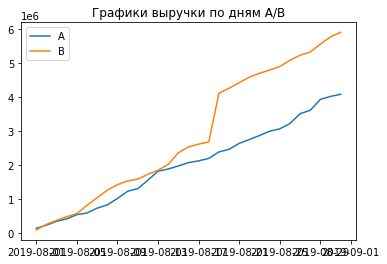

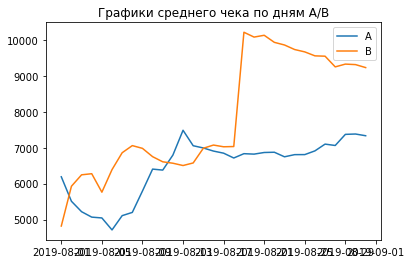

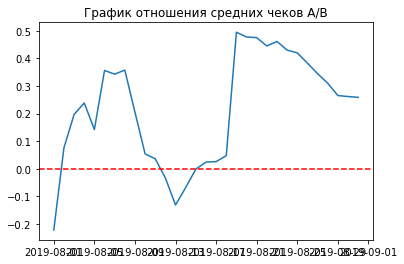

In [14]:
# построим график коммулятивной выручки по группам

cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим графики выручки групп
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')
plt.legend()
plt.title('Графики выручки по дням А/В')
plt.show()

#строим графики среднего чека
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B')
plt.legend()
plt.title('Графики среднего чека по дням А/В')

plt.show()


# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenueA.merge(cumulative_revenueB, on = 'date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('График отношения средних чеков А/В')
plt.show()

1. ***Выручка росла на протяжение всего теста в обоих группах, однако в какой то момент в В группе наблюдается скачек. Это может быть связано с увеличением количества заказов или же с продажей дорогостоящих товаров. Надо посмоттреть на выбросы в данных***
2. ***Средний чек группы А сначала стремительно падал, затем вырос а затем вновь упал и держался на определнном уровне. В то время как чек В сначала показал рост, затем небольшой спад, а потом подскочил в небо и начал снижаться. Подозреваю что были какие то дорогостоящие товары.***
3. ***На графике отношения средних чеков видны несколько скачкев в нескольких точках, предполагаю или резкий всплеск заказов или интерес к более дорогим товарам***

<a id="p2"></a>
### 4.  График кумулятивной конверсии по группам.
### 5. График относительного изменения кумулятивной конверсии группы B к группе A.


---------- Масштабы для графиков ----------
Диапозон дат 2019-08-01 00:00:00 2019-08-31 00:00:00
Диапозон конверсий 0.029 0.036
---------- ---------- ----------


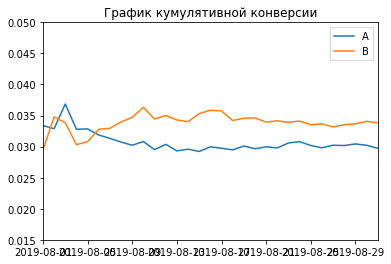

In [15]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A и по группе В
cumulative_dataA = cumulative_data[cumulative_data['group']=='A']
cumulative_dataB = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B')
plt.legend()

print('-' * 10,'Масштабы для графиков','-' * 10)
print('Диапозон дат',cumulative_dataA['date'].min(),cumulative_dataA['date'].max())
print('Диапозон конверсий',round(cumulative_dataB['conversion'].min(), 3),
      round(cumulative_dataB['conversion'].max(), 3))
print('-' * 10,'-' * 10,'-' * 10)

# задаем масштаб осей
plt.axis([cumulative_dataA['date'].min(),cumulative_dataA['date'].max(), 0.015, 0.05])
plt.title('График кумулятивной конверсии')
plt.show()

***На начальных этапах графики имели похожее поведение, затем пересеклись и разделились почти зеркально. Конверсия группы В очевидно вырвалась вперед, а значит имеет место быть увелечение заказов. Конверсии стали более стаабильны к середине эксперимента***

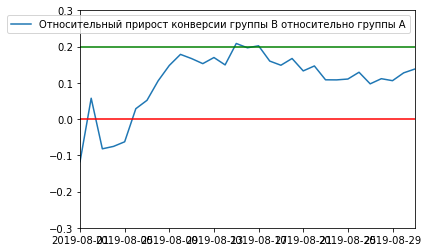

In [16]:
# Построим график относительного различия между конверсиями
### mcc - merged_cummulative_conversions
mcc = cumulative_dataA[['date','conversion']].merge(cumulative_dataB[['date','conversion']], on = 'date', how='left', suffixes=['A', 'B'])

plt.plot(mcc['date'], mcc['conversionB']/mcc['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0.2, color='green', linestyle='-')
plt.axhline(y=0, color='red', linestyle='-')


plt.axis([mcc['date'].min(), mcc['date'].max(), -0.3, 0.3])
plt.show()

***Согласно графика относительного прироста конверсий, Мы наблюдаем начальное повышение конверсии в пользу В, затем возврат почти на исходную, а вот потом отношение прироста В было увеличено почти в три раза, это свидетельствует о том, что конверсия группы В стала значительно выше.***

<a id="p3"></a>
### 6. Точечный график количества заказов по пользователям.
### 7. 95-й и 99-й перцентили количества заказов на пользователя.  Граница для определения аномальных пользователей.
### 8. Точечный график стоимостей заказов. 
### 9. 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
...,...,...
359,1484903144,1
360,1485964287,1
361,1494664757,1
362,1495112755,1


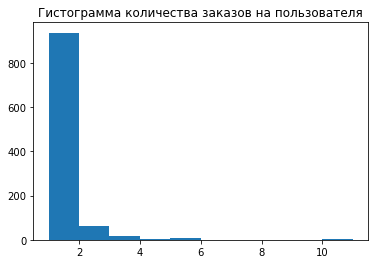

In [17]:
# сгруппируем по пользователю, чтобы получить количество заказов на пользователя
orders_by_users = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
orders_by_users.columns = ['visitorId', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False))

plt.hist(orders_by_users['orders'])
plt.title('Гистограмма количества заказов на пользователя')
plt.show()

***На гистограмме видно что большая часть пользователей заказывала 1-2 раза, но и 3-4 заказа хоть и меньше но тоже котируются и подойдут для дальнейшего исследования, видим также и 8 и 9 и 11 заказов на пользователя.***

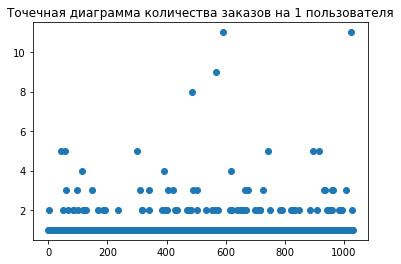

Процентили 95 и 99 количества заказов [2. 4.]


In [18]:
# построим точечную диаграмму числа заказов на пользователя, и посмотри процентили 95 и 99
x = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x, orders_by_users['orders'])
plt.title('Точечная диаграмма количества заказов на 1 пользователя')
plt.show()

percentiles = np.percentile(orders_by_users['orders'], [95,99])
print('Процентили 95 и 99 количества заказов', percentiles)

***Точечная диаграмма подтвердила что большинство пользователей сделали по 1 заказу, также 2-3 заказа тоже часто встречаются. Согласно процентилям лишь 1% аудитории сделали 4 заказа, 5 процентов аудитории выбрали более 2 заказов, следовательно стоит установить границу для аномалий -> *2 или 3* ***

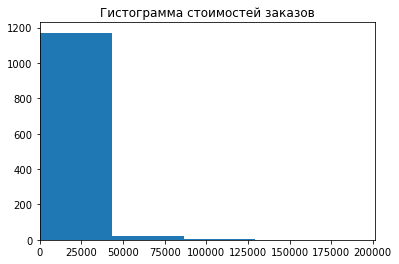

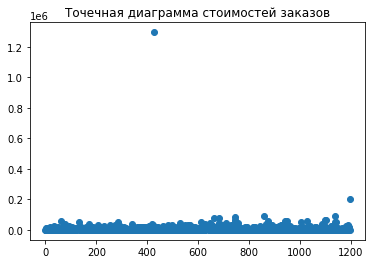

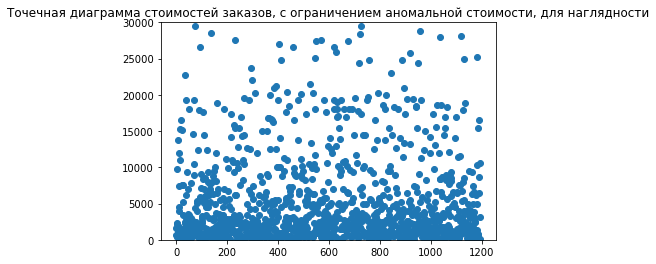

Процентили 95 и 99 стоимостей заказов [28000.  58233.2]


In [19]:
# построим точечную диаграмму стоимостей заказов и найдем процентили 95 и 99
plt.hist(orders['revenue'], bins=30)
plt.title('Гистограмма стоимостей заказов')
plt.xlim(0,201000)
plt.show()
x_revenue = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_revenue, orders['revenue'])
plt.title('Точечная диаграмма стоимостей заказов')
plt.show()

plt.scatter(x_revenue, orders['revenue'])
plt.ylim(0,30000)
plt.title('Точечная диаграмма стоимостей заказов, с ограничением аномальной стоимости, для наглядности')
plt.show()

percentiles_rev = np.percentile(orders['revenue'], [95,99])
print('Процентили 95 и 99 стоимостей заказов', percentiles_rev)




***На гистаграмме видно что есть заказы превышающие 75000 в цене и даже до 200000. Остальные заказы находятся в диапозоне от 0 до 40000. На точечном графике видно, что есть заказ дороже миллиона, он то нам статистику и портит. Данные перцентилей говорят ято 1 процент заказов стоил свыше 58 тысяч, а 5 процентов стоили выше 28000, стало быть и границу выберем в | 28 - 30 тысяч |***


#### Границы аномалий: цена выше 28 000, количество заказов выше 2

<a id="p4"></a>
### 10. Статистическая значимость различий в конверсии между группами по «сырым» данным. 
### 11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.
### 12. Статистическая значимость различий в конверсии между группами по «очищенным» данным.
### 13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [20]:
#визиты по дням A и В
visitorsA_daily = visits[visits['group']=='A'][['date', 'visitors']]
visitorsA_daily.columns = ['date', 'visitors_per_dateA']
visitorsB_daily = visits[visits['group']=='B'][['date', 'visitors']]
visitorsB_daily.columns = ['date', 'visitors_per_dateB']
#коммулятивные данные А и В
visitors_Acummulative = visitorsA_daily.apply(lambda x: visitorsA_daily[visitorsA_daily['date'] <= x['date']].agg(
    {'date' : 'max', 'visitors_per_dateA' : 'sum'}), axis=1)
visitors_Acummulative.columns = ['date', 'visitors_cummulativeA']
visitors_Bcummulative = visitorsB_daily.apply(lambda x: visitorsB_daily[visitorsB_daily['date'] <= x['date']].agg(
    {'date' : 'max', 'visitors_per_dateB' : 'sum'}), axis=1)
visitors_Bcummulative.columns = ['date', 'visitors_cummulativeB']

ordersA_daily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : 'nunique', 'revenue' : 'sum'})
ordersA_daily.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

ordersB_daily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : 'nunique', 'revenue' : 'sum'})
ordersB_daily.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

orders_Acummulative = ordersA_daily.apply(
    lambda x: ordersA_daily[ordersA_daily['date'] <= x['date']].agg(
        {'date' : 'max',
        'orders_per_dateA' : 'sum',
        'revenue_per_dateA' : 'sum'}), axis=1).sort_values(by=['date'])
orders_Acummulative.columns = ['date', 'orders_cummulativeA', 'revenue_cummulativeA']

orders_Bcummulative = ordersB_daily.apply(
    lambda x: ordersB_daily[ordersB_daily['date'] <= x['date']].agg(
        {'date' : 'max',
        'orders_per_dateB' : 'sum',
        'revenue_per_dateB' : 'sum'}), axis=1).sort_values(by=['date'])

orders_Bcummulative.columns = ['date', 'orders_cummulativeB', 'revenue_cummulativeB']

total_data = ordersA_daily.merge(ordersB_daily, on = 'date', how='left').merge(
    orders_Acummulative, on = 'date', how='left').merge(
    orders_Bcummulative, on = 'date', how='left').merge(
    visitorsA_daily, on = 'date', how='left').merge(
    visitorsB_daily, on = 'date', how='left').merge(
    visitors_Acummulative, on = 'date', how='left').merge(
    visitors_Bcummulative, on = 'date', how='left')
display(total_data.head(10))

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,orders_cummulativeA,revenue_cummulativeA,orders_cummulativeB,revenue_cummulativeB,visitors_per_dateA,visitors_per_dateB,visitors_cummulativeA,visitors_cummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935
6,2019-08-07,18,142417,24,225334,145,740818,153,1049671,644,709,4629,4644
7,2019-08-08,16,96279,27,220918,161,837097,180,1270589,610,654,5239,5298
8,2019-08-09,16,188506,25,160812,177,1025603,205,1431401,617,610,5856,5908
9,2019-08-10,16,210495,23,107802,193,1236098,228,1539203,406,369,6262,6277


#### Описание данных total_data
    date — дата;
    orders_per_dateA — количество заказов в выбранную дату в группе A;
    revenue_per_dateA — суммарная выручка в выбранную дату в группе A;
    orders_per_dateB — количество заказов в выбранную дату в группе B;
    revenue_per_dateB — суммарная выручка в выбранную дату в группе B;
    orders_cummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
    revenue_cummulativeA — суммарная выручка до выбранной даты включительно в группе A;
    orders_cummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
    revenue_cummulativeB — суммарная выручка до выбранной даты включительно в группе B;
    visitors_per_dateA — количество пользователей в выбранную дату в группе A;
    visitors_per_dateB — количество пользователей в выбранную дату в группе B;
    visitors_cummulativeA — количество пользователей до выбранной даты включительно в группе A;
    visitors_cummulativeB — количество пользователей до выбранной даты включительно в группе B.


In [21]:
# Посчитаем статистическую значимость различия в конверсии между группами.
# Сделаем две группировки по А и В и сосчитаем кто заказывал хотябы 1 раз

#REMEMBER ME
#VISITS['date', 'group', 'visitors']
#ORDERS ['transactionId', 'visitorId', 'date', 'revenue', 'group']

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg(
    {'transactionId' : 'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg(
    {'transactionId' : 'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули.
# Чтобы подготовить выборки к проверке критерием Манна-Уитни.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(total_data['visitors_per_dateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(total_data['visitors_per_dateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [22]:
# напишем фугкцию для проверки гипотез
def check_hypotese(sampA, sampB, alpha, subject):
    """Функция принимает 4 аргумента это 2 набора данных,
        уровень статистической значимости alpha и subject это предмет изучения.
        Возвращает расчитанный p-value и относительную разницу данных выборок"""
    p_value = st.mannwhitneyu(sampA, sampB, alternative = 'two-sided')[1]
    diff = sampB.mean()/sampA.mean() - 1
    print('{0} p-value = {1:.3f}'.format(subject, p_value))
    print('Относительная разница {0} = {1:.3f}'.format(subject, diff))
    if p_value < alpha:
        return display('Нулеваая гипотезу стоит отвергнуть')
    else:
        return display('Нулевую гипотезу отврегать не стоит')
    

### Формулировка гипотез для критерия Мана Уитни(конверсии):

#### Ho "Статистически значимых отличий в конверсии между группами нет"
#### H1 "Статистически значимые отличия в конверсии есть"

In [23]:
# вызовем функции проверки гипотезы
check_hypotese(sampleA, sampleB, 0.05, 'Конверсия')

Конверсия p-value = 0.017
Относительная разница Конверсия = 0.138


'Нулеваая гипотезу стоит отвергнуть'

1. ***Вывод по статичтической значимости конверсии, Ман Уинти меньше уровня стат значимости в 0.05, а значит нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.***
2. ***Относительный выигрыш группы В равен 13,8 процентам.***

#### Нулевая гипотеза отвергнута

### Формулировка гипотез для критерия Мана Уитни(средний чек):

#### Ho "Статистически значимых отличий в среднем чеке между группами нет"
#### H1 "Статистически значимые отличия в среднем чеке есть"

In [24]:
# найдем относительные отличия в среднем чеке

sampA,sampB = orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue']
check_hypotese(sampA, sampB, 0.05, 'Средний чек')

Средний чек p-value = 0.729
Относительная разница Средний чек = 0.259


'Нулевую гипотезу отврегать не стоит'

1. ***P-value больше чем 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.***
2. ***Впрочем, средний чек группы B значительно выше среднего чека группы A.***

#### Нулевая гипотеза принята не отвергнута

In [25]:
# 95-й и 99-й перцентили средних чеков равны 28 000 и 58 000.
# А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4.
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']],
                                axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders],
                          axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(10))
print('Аномальных пользователей =',abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
684     358944393
648     382846391
1189    393266494
68      457167155
68      611059232
dtype: int64

Аномальных пользователей = 74


### Формулировка гипотез для критерия Мана Уитни в аномальных данных(Конверсии):

#### Ho "Статистически значимых отличий в конверсии аномальных данных между группами нет"
#### H1 "Статистически значимые отличия в конверсии аномальных данных чеке есть"

In [26]:
# Посчитаем стат значимость конверсии в очищенных данных
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(total_data['visitors_per_dateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(total_data['visitors_per_dateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

check_hypotese(sampleAFiltered, sampleBFiltered, 0.05, 'Конверсии Аномалии')

Конверсии Аномалии p-value = 0.013
Относительная разница Конверсии Аномалии = 0.173


'Нулеваая гипотезу стоит отвергнуть'

***Уровень стат значимости практически не изменился, при этом относительный выигрыш группы В вырос  на 3.8 процента. Не сказать что результаты по конверсии сильно изменились нулевая гипотеза о том что различий нет, по прежнему отвергается***

#### Нулевая гипотеза отвергнута

### Формулировка гипотез для критерия Мана Уитни в аномальных данных(Средний чек):

#### Ho "Статистически значимых отличий в среднем чеке аномальных данных между группами нет"
#### H1 "Статистически значимые отличия в среднем чеке аномальных данных чеке есть"

In [27]:

sampA = orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

sampB = orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

check_hypotese(sampA, sampB, 0.05, 'Средний чек Аномалии')


Средний чек Аномалии p-value = 0.738
Относительная разница Средний чек Аномалии = -0.020


'Нулевую гипотезу отврегать не стоит'

***p-value остался практически таким же что и в сырых данных, а вот отношение среднего чека между сегментами упало значительно на 28 процентов. Удивительно но при том же уровне значимости, относительная разница средних чеков перевалил в пользу группы А. Тест Мана Уинти не чувствителен к аномальным данным.***
#### Нулевая гипотеза не отвергнута

<a id="total"></a>
# Общие вывод по проекту

### ЧАСТЬ I. Приоритарность гипотез
1. ICE показал приритет гиппотез в таком порядке: Запустить акцию, дающую скидку на товар в день рождения.
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

2. RICE показал другой приоритет: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

3. Приоретизация в случае RICE изменилась и вот почему:
    - ICE не учитывает параметр REACH, поэтому акция в день рождения лидирует в ICE ведь это заденет лишь 1 человека, здесь и ICE и RICE имеют равный показатель, а в случае с RICE она занимает лишь 5 место.
    - 3-е место в ICE занимает добавление формы подписки чтобы собрать базу клиентов, опять же здесь параметр REACH дает 10ти кратное уножение в пользу этой гипотезы в случае с RICE при техже условиях эта гипотеза первая в списке.
    - В случае с добавлением двух новых каналов трафика и привлечь 30% пользователей, в случае с ICE это вторая по значимости гипотеза так как ее показатели влияния на пользователя 10 и уверненность 8 при стоимости в 6, в тоже время эта гипотеза занимает третье место в RICE и к ее показателям добавляется REACH и это еще 3 единицы в пользу такой гипотезы.
    - В случае с добавлением блока рекомендаций товаров на сайт магазина, чтобы повысить конверсию, в ICE это 4 место а в случае с RICE второе, дело в том что это изменение не сильно повлияет на пользователей, однако уверенность в нем высокая а стоимость дешевая. При количестве REACH в 8 эта гипотеза занимает честное второе место в RICE.

***Общий вывод при высоких Impact Confidence и низком Efforts, гипотеза по версии ICE всегда будет лидировать, но если REACH при этом 1 то при таких же условиях другой гипотезы и REACH больше хотябы на 1, гипотеза по версии RICE станет приоритетной***

## ЧАСТЬ II. Аналитика A/B теста

Итак что мы имеем факты:
1. Уровень статистической значимости конверсий не изменился по сравнению сырых данных и филтрованных от аномалий. Нулевая гипотеза отвергнута.
2. Статистически значимого различия между сырым средним чеком и фильтрованным также не было обнаружено, хотя и в аномальных данных отношения среднего чека перевалило в пользу А, просто тест Мана Уитни не чувствителен к выбросам аномальным. А вот отношения прироста В чека был уменьшен на более 4 процента по сравнению с сырыми данными.
3. График отличия конверсий по группам сообщает что результаты В выглядят лучше и есть тенденция к улучшению, в начале есть отрицательные значения, но затем конверсия В приобладает.
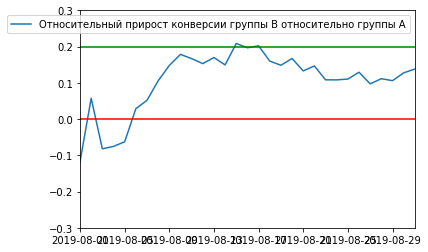
4. График различия среднего чека говорит о том, что группа В сначала был стремительный рост, падение и затем рост в 1,5 раза выше предыдущего максимума. Еще одно очко в пользу группы В.
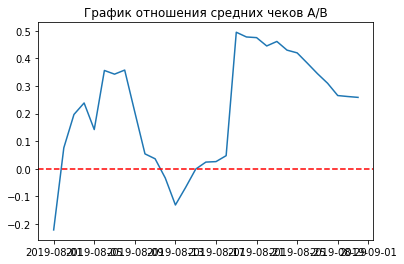


**Исходя из обнаруженных фактов и времени затраченного на тестирование: предлагаю остановить тест и зафиксировать победу группы В**